In [1]:
from pathlib import Path
from abc_atlas_access.abc_atlas_cache.abc_project_cache import AbcProjectCache
import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
from tools import *

/opt/anaconda3/envs/rna/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load the data. 

In [2]:
download_base = Path('./data/abc_atlas')
abc_cache = AbcProjectCache.from_cache_dir(download_base)

path  = abc_cache.get_data_path(directory='Zeng-Aging-Mouse-10Xv3', file_name='Zeng-Aging-Mouse-10Xv3/log2')
adata = sc.read_h5ad(path)

Load the metadata. 

In [3]:
# load metadata
cell = abc_cache.get_metadata_dataframe(
    directory='Zeng-Aging-Mouse-10Xv3',
    file_name='cell_metadata',
    dtype={'cell_label': str,
           'wmb_cluster_alias': 'Int64'}
)
cell.set_index('cell_label', inplace=True)

In [4]:
# load metadata
cluster_info = abc_cache.get_metadata_dataframe(
    directory='Zeng-Aging-Mouse-10Xv3',
    file_name='cluster'
).set_index('cluster_alias')
# Join the cluster information in by joining on the Aging dataset's cluster_alias column.
cell_extended = cell.join(cluster_info, on='cluster_alias', rsuffix='_cl_info')
cell_cluster_mapping = abc_cache.get_metadata_dataframe(
    directory='Zeng-Aging-Mouse-WMB-taxonomy',
    file_name='cell_cluster_mapping_annotations'
).set_index('cell_label')
cell_extended = cell_extended.join(cell_cluster_mapping, rsuffix='_cl_map')
# Quick run through to drop duplicated columns
drop_cols = []
for col in cell_extended.columns:
    if col.endswith(('_cl_map', '_cl_colors', '_cl_info')):
        drop_cols.append(col)
cell_extended.drop(columns=drop_cols, inplace=True)

Load the age-DE genes. 

In [5]:
# load all degenes
degenes = abc_cache.get_metadata_dataframe(
    directory='Zeng-Aging-Mouse-WMB-taxonomy',
    file_name='aging_degenes'
)

In [6]:
# get the subclass names
subclass_names = cell_extended['subclass_name'].unique()

Define the subclass we want to analysis. 

In [7]:
# target subclasses with different number of degene counts
age_DE_high_subclass = ['L4 RSP-ACA Glut', 'TU-ARH Otp Six6 Gaba', 'PVH-SO-PVa Otp Glut', 'PRP-NI-PRNc-GRN Otp Glut']
age_DE_medium_subclass = ['STR D1 Gaba', 'DG Glut', 'OB-STR-CTX Inh IMN', 'DMH-LHA Gsx1 Gaba', 'PG-TRN-LRN Fat2 Glut']
age_DE_low_subclass = ['Vip Gaba', 'MPO-ADP Lhx8 Gaba', 'PH-an Pitx2 Glut', 'ND-INC Foxd2 Glut', 'NTS Dbh Glut']

aged_high = name_with_index(age_DE_high_subclass, subclass_names)
aged_medium = name_with_index(age_DE_medium_subclass, subclass_names)
aged_low = name_with_index(age_DE_low_subclass, subclass_names)

Define regression method. 

In [8]:
# define regression functions
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import statsmodels.api as sm


def select_important_feature_logistic(X, y, C=1e-3):

    X_with_intercept = sm.add_constant(X)
    lasso_logreg = LogisticRegression(penalty='l1', solver='liblinear', C=C)

    lasso_logreg.fit(X_with_intercept, y)

    important_features = np.where(lasso_logreg.coef_[0] != 0)[0]

    y_pred = lasso_logreg.predict(X_with_intercept)
    acc = accuracy_score(y, y_pred)

    return lasso_logreg, important_features, acc


def lasso_logistic_on_svd(adata, 
                      metadata,
                      regression_terms=['donor_age_category_order'],
                      C=1e-3): 
    
    adata = assign_binary_regression_labels(adata, metadata, regression_terms)
    X = adata.obsm['X_pca']
    X_with_intercept = sm.add_constant(X)
    y = adata.obs['regression_labels']

    lasso_logreg, important_features, acc = select_important_feature_logistic(X_with_intercept, y, C=C)
    return adata, lasso_logreg, important_features, acc

In [9]:
def logistic_regression(adata, 
                      metadata,
                      regression_terms=['donor_age_category_order'],
                      alpha=0.01):
    adata = assign_binary_regression_labels(adata, metadata, regression_terms)
    X = adata.obsm['X_pca']
    X_with_intercept = sm.add_constant(X)
    y = adata.obs['regression_labels']

    logit_model = sm.Logit(y, X_with_intercept)
    result = logit_model.fit(method='cg')

    y_pred = result.predict(X_with_intercept) > 0.5
    acc = accuracy_score(y, y_pred)

    pvals = result.pvalues
    n_feature = X_with_intercept.shape[1]
    important_features = np.where(pvals < alpha/n_feature)[0]

    return adata, result, important_features, acc


Analyze data from L4 RSP-ACA Glut subclass. 

In [10]:
# detect degenes by subclass

subclass_name = aged_high[0]
degenes_subclass = degenes[degenes['grouping_name'] == subclass_name]
subclass_adata, subclass_cells = filter_cells_by_anaotation(adata, cell_extended, 'subclass_name', subclass_name)
subclass_adata = filter_genes_by_expression(subclass_adata)
sc.tl.pca(subclass_adata, n_comps=50)

/opt/anaconda3/envs/rna/lib/python3.12/site-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


In [11]:
subclass_adata

AnnData object with n_obs × n_vars = 1725 × 12494
    obs: 'cell_barcode', 'library_label', 'anatomical_division_label', 'alignment_job_id'
    var: 'gene_symbol'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

Logistic regression without LASSO. 

In [12]:
_, logit, important_features_logit, acc_logit = logistic_regression(
                        subclass_adata, subclass_cells, regression_terms=['donor_age_category'], alpha=0.10)
print(f"Classification accuracy for {subclass_name}: {acc_logit}")


         Current function value: 0.000492
         Iterations: 35
         Function evaluations: 55
         Gradient evaluations: 55
Classification accuracy for 021 L4 RSP-ACA Glut: 1.0


/opt/anaconda3/envs/rna/lib/python3.12/site-packages/scipy/optimize/_optimize.py:1680: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_cg(f, x0, args, fprime, callback=callback, c1=c1, c2=c2,
/opt/anaconda3/envs/rna/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [13]:
subclass_adata.obs['regression_labels'].value_counts()

regression_labels
0.0    938
1.0    787
Name: count, dtype: int64

In [14]:
logit.summary()
# complete quasi-separation problem. Regularization necessary

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:      regression_labels   No. Observations:                 1725
Model:                          Logit   Df Residuals:                     1674
Method:                           MLE   Df Model:                           50
Date:                Thu, 13 Mar 2025   Pseudo R-squ.:                  0.9993
Time:                        17:10:47   Log-Likelihood:               -0.84817
converged:                      False   LL-Null:                       -1189.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0673      3.665     -0.018      0.985      -7.250       7.116
x1            -0.1490      0.089     -1.667      0.095      -0.324       0.026
x2            -0.2266      0.135     -1.683      0.092      -0.491       0.037
x3             0.5616      0.248      2.261      0.024       0.075       1.048
x4             0.3363      0.169      1.995      0.046       0.006       0.667
x5             0.6762      0.314      2.152      0.031       0.060       1.292
x6            -0.0503      0.215     -0.234      0.815      -0.471       0.370
x7            -0.2339      0.215     -1.088      0.277      -0.655       0.188
x8             0.0383      0.184      0.209      0.835      -0.322       0.399
x9             0.0412      0.213      0.194      0.846      -0.375       0.458
x10            0.2318      0.221      1.051      0.293      -0.201       0.664
x11           -0.0769      0.411     -0.187      0.852      -0.883       0.729
x12            0.0261      0.266      0.098      0.922      -0.494       0.547
x13            0.0515      0.342      0.151      0.880      -0.619       0.722
x14            0.3373      0.367      0.920      0.358      -0.381       1.056
x15           -0.2184      0.321     -0.680      0.497      -0.848       0.412
x16           -0.0244      0.339     -0.072      0.943      -0.689       0.640
x17            0.0652      0.341      0.191      0.849      -0.604       0.734
x18           -0.0291      0.274     -0.106      0.916      -0.567       0.509
x19            0.0340      0.387      0.088      0.930      -0.724       0.792
x20            0.0709      0.500      0.142      0.887      -0.908       1.050
x21           -0.0603      0.395     -0.153      0.879      -0.834       0.714
x22            0.0311      0.389      0.080      0.936      -0.732       0.794
x23            0.0064      0.400      0.016      0.987      -0.777       0.790
x24            0.1726      0.506      0.341      0.733      -0.819       1.164
x25            0.0195      0.351      0.055      0.956      -0.668       0.707
x26            0.0183      0.400      0.046      0.963      -0.766       0.802
x27           -0.1903      0.395     -0.482      0.630      -0.965       0.584
x28            0.0722      0.518      0.139      0.889      -0.943       1.088
x29            0.0334      0.395      0.084      0.933      -0.742       0.808
x30           -0.0857      0.429     -0.200      0.842      -0.926       0.755
x31           -0.1420      0.367     -0.387      0.699      -0.862       0.578
x32           -0.0026      0.350     -0.007      0.994      -0.689       0.684
x33            0.0774      0.442      0.175      0.861      -0.790       0.945
x34           -0.0271      0.471     -0.058      0.954      -0.951       0.896
x35            0.1293      0.325      0.397      0.691      -0.508       0.767
x36            0.0689      0.341      0.202      0.840      -0.599       0.737
x37            0.0518      0.328      0.158      0.874      -0.590       0.694
x3

We meet quasi-separation problem, where all p-values are large. Try logistic with LASSO. 

In [15]:
C = 1e-3
subclass_adata, lasso_logreg, important_features, acc = lasso_logistic_on_svd(
                        subclass_adata, subclass_cells, regression_terms=['donor_age_category'], C=C
                        )
print(f"Classification accuracy for {subclass_name}: {acc}")
print(f"Number of selected features: {len(important_features)}")

Classification accuracy for 021 L4 RSP-ACA Glut: 0.976231884057971
Number of selected features: 6


Visualize the result with SHAP. 

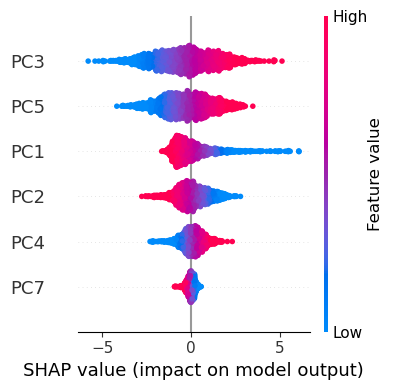

In [16]:
n_selected_features = len(important_features)
shap_values = shap_importance_analysis(lasso_logreg, subclass_adata, max_display=n_selected_features)
sorted_indices = order_loadings_by_shap(shap_values)
selected_features = sorted_indices[:n_selected_features]
loading_idx = [i-1 for i in selected_features]

In [17]:
n_genes_per_pc=200
degenes_detected_among_all, degenes_detected_among_extracted = detect_degenes_accumulated(
                        subclass_adata, loading_idx, degenes_subclass['gene_symbol'], n_genes_per_pc=n_genes_per_pc
                        )

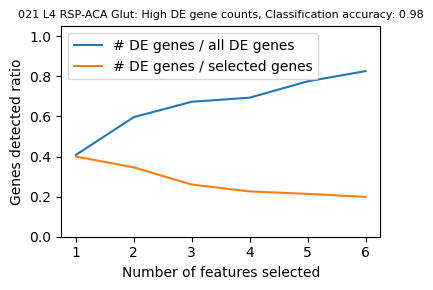

In [18]:
plot_degene_trend(n_selected_features, degenes_detected_among_all, degenes_detected_among_extracted, acc, 'High DE gene counts', subclass_name)

Analyze data from STR D1 Gaba subclass. 

In [19]:
# detect degenes by subclass

subclass_name = aged_medium[0]
degenes_subclass = degenes[degenes['grouping_name'] == subclass_name]
subclass_adata, subclass_cells = filter_cells_by_anaotation(adata, cell_extended, 'subclass_name', subclass_name)
subclass_adata = filter_genes_by_expression(subclass_adata)
sc.tl.pca(subclass_adata, n_comps=50)

/opt/anaconda3/envs/rna/lib/python3.12/site-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


In [20]:
subclass_adata

AnnData object with n_obs × n_vars = 21832 × 11647
    obs: 'cell_barcode', 'library_label', 'anatomical_division_label', 'alignment_job_id'
    var: 'gene_symbol'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

Logistic regression without LASSO. 

In [21]:
_, logit, important_features_logit, acc_logit = logistic_regression(
                        subclass_adata, subclass_cells, regression_terms=['donor_age_category'], alpha=0.10)
print(f"Classification accuracy for {subclass_name}: {acc_logit}")

         Current function value: 0.051240
         Iterations: 35
         Function evaluations: 60
         Gradient evaluations: 60
Classification accuracy for 061 STR D1 Gaba: 0.9821821179919384


/opt/anaconda3/envs/rna/lib/python3.12/site-packages/scipy/optimize/_optimize.py:1680: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_cg(f, x0, args, fprime, callback=callback, c1=c1, c2=c2,
/opt/anaconda3/envs/rna/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [22]:
logit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:      regression_labels   No. Observations:                21832
Model:                          Logit   Df Residuals:                    21781
Method:                           MLE   Df Model:                           50
Date:                Thu, 13 Mar 2025   Pseudo R-squ.:                  0.9248
Time:                        17:12:06   Log-Likelihood:                -1118.7
converged:                      False   LL-Null:                       -14866.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2542      0.065     -3.910      0.000      -0.382      -0.127
x1             0.0126      0.001      9.127      0.000       0.010       0.015
x2             0.0505      0.002     21.796      0.000       0.046       0.055
x3            -0.0067      0.002     -2.906      0.004      -0.011      -0.002
x4            -0.0734      0.003    -22.350      0.000      -0.080      -0.067
x5             0.1438      0.005     30.327      0.000       0.135       0.153
x6             0.0628      0.004     17.496      0.000       0.056       0.070
x7            -0.1966      0.006    -32.598      0.000      -0.208      -0.185
x8             0.0733      0.004     17.117      0.000       0.065       0.082
x9            -0.1510      0.006    -23.988      0.000      -0.163      -0.139
x10           -0.2706      0.009    -31.734      0.000      -0.287      -0.254
x11           -0.1504      0.006    -24.186      0.000      -0.163      -0.138
x12           -0.1901      0.007    -27.156      0.000      -0.204      -0.176
x13           -0.1870      0.007    -25.975      0.000      -0.201      -0.173
x14           -0.0388      0.006     -6.760      0.000      -0.050      -0.028
x15            0.4596      0.013     35.940      0.000       0.435       0.485
x16           -0.1316      0.007    -17.927      0.000      -0.146      -0.117
x17            0.1596      0.008     20.094      0.000       0.144       0.175
x18            0.0726      0.007      9.937      0.000       0.058       0.087
x19           -0.1145      0.008    -14.818      0.000      -0.130      -0.099
x20           -0.0362      0.008     -4.639      0.000      -0.051      -0.021
x21           -0.1503      0.008    -17.774      0.000      -0.167      -0.134
x22           -0.1699      0.009    -19.637      0.000      -0.187      -0.153
x23           -0.1219      0.009    -13.944      0.000      -0.139      -0.105
x24            0.0466      0.008      5.529      0.000       0.030       0.063
x25           -0.2044      0.011    -19.048      0.000      -0.225      -0.183
x26            0.5005      0.015     32.753      0.000       0.471       0.530
x27           -0.0344      0.009     -3.845      0.000      -0.052      -0.017
x28            0.1929      0.010     18.551      0.000       0.173       0.213
x29            0.1519      0.010     15.146      0.000       0.132       0.172
x30           -0.0041      0.009     -0.439      0.661      -0.023       0.014
x31            0.0165      0.010      1.665      0.096      -0.003       0.036
x32            0.1562      0.011     14.419      0.000       0.135       0.177
x33           -0.1130      0.011    -10.716      0.000      -0.134      -0.092
x34            0.0535      0.010      5.099      0.000       0.033       0.074
x35           -0.0283      0.011     -2.680      0.007      -0.049      -0.008
x36            0.2968      0.012     23.979      0.000       0.273       0.321
x37            0.2417      0.012     19.408      0.000       0.217       0.266
x3

We meet quasi-separation problem, where all p-values are small. Try logistic with LASSO. 

In [23]:
subclass_adata.obs['regression_labels'].value_counts()

regression_labels
0.0    12619
1.0     9213
Name: count, dtype: int64

In [24]:
C = 5e-5
subclass_adata, lasso_logreg, important_features, acc = lasso_logistic_on_svd(
                            subclass_adata, subclass_cells, regression_terms=['donor_age_category'], C=C
                            )
print(f"Classification accuracy for {subclass_name}: {acc}")
print(f"Number of selected features: {len(important_features)}")

Classification accuracy for 061 STR D1 Gaba: 0.8046903627702455
Number of selected features: 8


In [25]:
subclass_adata.obs['regression_labels'].value_counts()

regression_labels
0.0    12619
1.0     9213
Name: count, dtype: int64

Visualize the result with SHAP. 

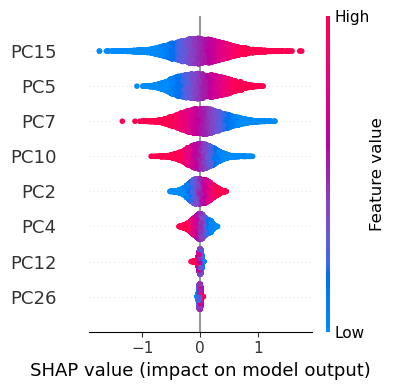

In [26]:
n_selected_features = len(important_features)
shap_values = shap_importance_analysis(lasso_logreg, subclass_adata, max_display=n_selected_features)
sorted_indices = order_loadings_by_shap(shap_values)
selected_features = sorted_indices[:n_selected_features]
loading_idx = [i-1 for i in selected_features]

In [27]:
n_genes_per_pc=200
degenes_detected_among_all, degenes_detected_among_extracted = detect_degenes_accumulated(
                            subclass_adata, loading_idx, degenes_subclass['gene_symbol'], n_genes_per_pc=n_genes_per_pc
                            )

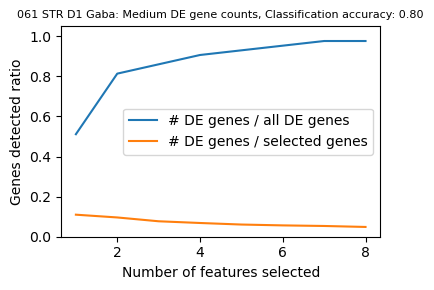

In [28]:
plot_degene_trend(n_selected_features, degenes_detected_among_all, degenes_detected_among_extracted, acc, 'Medium DE gene counts', subclass_name)

Analyze data from Vip Gaba subclass. 

In [29]:
# detect degenes by subclass

subclass_name = aged_low[0]
degenes_subclass = degenes[degenes['grouping_name'] == subclass_name]
subclass_adata, subclass_cells = filter_cells_by_anaotation(adata, cell_extended, 'subclass_name', subclass_name)
subclass_adata = filter_genes_by_expression(subclass_adata)
sc.tl.pca(subclass_adata, n_comps=50)

/opt/anaconda3/envs/rna/lib/python3.12/site-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


In [30]:
subclass_adata

AnnData object with n_obs × n_vars = 9205 × 11162
    obs: 'cell_barcode', 'library_label', 'anatomical_division_label', 'alignment_job_id'
    var: 'gene_symbol'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

Logistic regression without LASSO. 

In [31]:
_, logit, important_features_logit, acc_logit = logistic_regression(
                        subclass_adata, subclass_cells, regression_terms=['donor_age_category'], alpha=0.10)
print(f"Classification accuracy for {subclass_name}: {acc_logit}")

         Current function value: 0.162460
         Iterations: 35
         Function evaluations: 61
         Gradient evaluations: 61
Classification accuracy for 046 Vip Gaba: 0.9386203150461706


/opt/anaconda3/envs/rna/lib/python3.12/site-packages/scipy/optimize/_optimize.py:1680: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_cg(f, x0, args, fprime, callback=callback, c1=c1, c2=c2,
/opt/anaconda3/envs/rna/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [32]:
logit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:      regression_labels   No. Observations:                 9205
Model:                          Logit   Df Residuals:                     9154
Method:                           MLE   Df Model:                           50
Date:                Thu, 13 Mar 2025   Pseudo R-squ.:                  0.7594
Time:                        17:13:16   Log-Likelihood:                -1495.4
converged:                      False   LL-Null:                       -6215.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5675      0.048     11.878      0.000       0.474       0.661
x1            -0.0188      0.001    -17.677      0.000      -0.021      -0.017
x2             0.0001      0.001      0.083      0.934      -0.003       0.003
x3            -0.0092      0.002     -5.177      0.000      -0.013      -0.006
x4            -0.0012      0.002     -0.611      0.541      -0.005       0.003
x5             0.0086      0.002      3.872      0.000       0.004       0.013
x6            -0.0242      0.003     -8.346      0.000      -0.030      -0.019
x7            -0.0297      0.003     -9.507      0.000      -0.036      -0.024
x8            -0.0178      0.003     -5.917      0.000      -0.024      -0.012
x9            -0.0446      0.004    -11.578      0.000      -0.052      -0.037
x10           -0.1033      0.004    -23.748      0.000      -0.112      -0.095
x11            0.0490      0.004     11.465      0.000       0.041       0.057
x12           -0.1678      0.006    -28.977      0.000      -0.179      -0.156
x13            0.0697      0.005     14.300      0.000       0.060       0.079
x14           -0.0219      0.005     -4.753      0.000      -0.031      -0.013
x15           -0.1017      0.006    -17.676      0.000      -0.113      -0.090
x16            0.0910      0.005     16.967      0.000       0.081       0.102
x17           -0.0739      0.006    -12.753      0.000      -0.085      -0.063
x18            0.0576      0.006     10.382      0.000       0.047       0.068
x19            0.0535      0.006      9.463      0.000       0.042       0.065
x20            0.0055      0.006      0.965      0.335      -0.006       0.017
x21           -0.0797      0.006    -12.558      0.000      -0.092      -0.067
x22            0.0309      0.006      5.231      0.000       0.019       0.042
x23            0.1098      0.007     16.865      0.000       0.097       0.123
x24           -0.0938      0.007    -14.358      0.000      -0.107      -0.081
x25           -0.4122      0.011    -37.544      0.000      -0.434      -0.391
x26            0.0387      0.006      6.000      0.000       0.026       0.051
x27           -0.2914      0.009    -31.839      0.000      -0.309      -0.273
x28           -0.0582      0.007     -8.599      0.000      -0.071      -0.045
x29            0.1436      0.008     18.211      0.000       0.128       0.159
x30           -0.0677      0.007     -9.558      0.000      -0.082      -0.054
x31            0.0603      0.007      8.391      0.000       0.046       0.074
x32            0.0014      0.007      0.198      0.843      -0.013       0.016
x33           -0.0909      0.007    -12.154      0.000      -0.106      -0.076
x34            0.0442      0.008      5.782      0.000       0.029       0.059
x35            0.0310      0.008      4.047      0.000       0.016       0.046
x36           -0.0769      0.008     -9.898      0.000      -0.092      -0.062
x37            0.0270      0.008      3.434      0.001       0.012       0.042
x3

We meet quasi-separation problem, where all p-values are small. Try logistic with LASSO. 

In [33]:
subclass_adata.obs['regression_labels'].value_counts()

regression_labels
1.0    5470
0.0    3735
Name: count, dtype: int64

In [34]:
C = 2e-4
subclass_adata, lasso_logreg, important_features, acc = lasso_logistic_on_svd(
                            subclass_adata, subclass_cells, regression_terms=['donor_age_category'], C=C
                            )
print(f"Classification accuracy for {subclass_name}: {acc}")
print(f"Number of selected features: {len(important_features)}")

Classification accuracy for 046 Vip Gaba: 0.8334600760456273
Number of selected features: 7


Visualize the result with SHAP. 

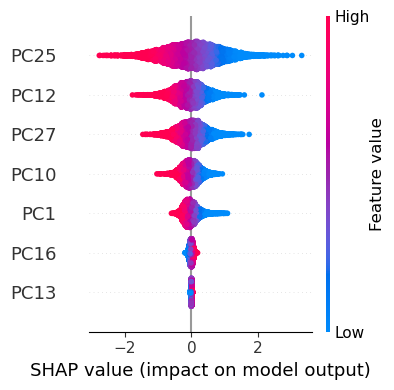

In [35]:
n_selected_features = len(important_features)
shap_values = shap_importance_analysis(lasso_logreg, subclass_adata, max_display=n_selected_features)
sorted_indices = order_loadings_by_shap(shap_values)
selected_features = sorted_indices[:n_selected_features]
loading_idx = [i-1 for i in selected_features]

In [36]:
n_genes_per_pc=200
degenes_detected_among_all, degenes_detected_among_extracted = detect_degenes_accumulated(
                            subclass_adata, loading_idx, degenes_subclass['gene_symbol'], n_genes_per_pc=n_genes_per_pc
                            )

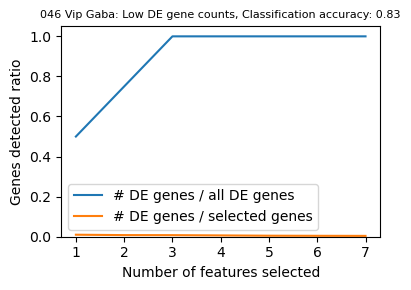

In [37]:
plot_degene_trend(n_selected_features, degenes_detected_among_all, degenes_detected_among_extracted, acc, 'Low DE gene counts', subclass_name)